In [1]:
import json
import os
import statistics

import matplotlib.pyplot as plt
import numpy as np

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import koger_tracking as ktf
import koger_general_functions as kgf

plt.style.use('dark_background')

In [2]:
observation_name = "observation003"

base_folder = os.path.join(local_paths['processed_folder'], observation_name)

# This is the output file we are creating with this notebook
tracks_file = os.path.join(base_folder, "raw_tracks.npy")
if os.path.isfile(tracks_file):
    print("Warning, tracks already exist for this observation.")

# list of dicts that contains keys "pred_boxes", "scores", "pred_classes", 
# "image_name" for each frame
detections_file = os.path.join(base_folder, f"{observation_name}_detections.npy")
detections_dicts = np.load(detections_file, allow_pickle=True)

# Use positions already extracted from bounding boxes if available
positions_file = os.path.join(base_folder, f"{observation_name}_positions.npy")
positions_exists = os.path.isfile(positions_file)
if os.path.isfile(positions_file):
    print("Using already computed postions.  Ignoring box files...")
    positions = np.load(positions_file, allow_pickle=True)
else:
    #get positions from boxes -> take the center of the box for the position
    positions = []
    for d_dict in detections_dicts:
        boxes = d_dict['pred_boxes']
        positions.append(ktf._get_boxes_center(boxes))
    np.save(positions_file, positions)

Warning, tracks already exist for this observation.
Using already computed postions.  Ignoring box files...


### Remove low confidence detections and visualize remaining

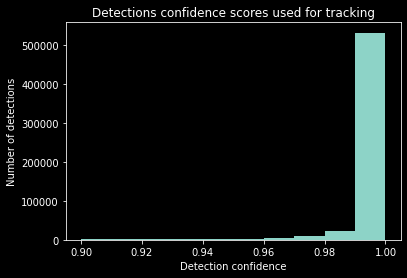

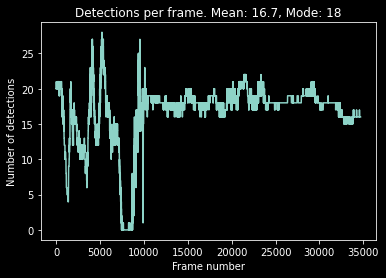

In [3]:
score_thresh = .9

for dict_ind, detection_dict in enumerate(detections_dicts):
    scores = detection_dict['scores']
    positions[dict_ind] = positions[dict_ind][np.where(scores > score_thresh)]
    detections_dicts[dict_ind]['scores'] = detection_dict['scores'][np.where(scores > score_thresh)]
    
# Overal detection confidence
all_scores = []
for d_dict in detections_dicts:
    scores = d_dict['scores']
    if len(scores) > 0:
        for score in scores:
            all_scores.append(score)
plt.figure()
_ = plt.hist(all_scores)
_ = plt.xlabel("Detection confidence")
_ = plt.ylabel("Number of detections")
_ = plt.title("Detections confidence scores used for tracking")

# Detections per frame
detections_per_frame = []
for frame_positions in positions:
    detections_per_frame.append(frame_positions.shape[0])
    
plt.figure()
plt.plot(detections_per_frame)
mean_detections = np.mean(detections_per_frame)
mode_detections = statistics.mode(detections_per_frame)
_ = plt.title(f"Detections per frame. Mean: {mean_detections:.1f}, Mode: {mode_detections}")
_ = plt.xlabel("Frame number")
_ = plt.ylabel('Number of detections')

### Do the actual tracking

In [4]:
first_frame_ind = 0

params = {'max_distance_threshold': 120,
          'max_distance_threshold_noise': 30,
          'min_distance_threshold': 0,
          'max_unseen_time': 20,
          'min_new_track_distance': 10,
          'new_track_noise': 10,
          'max_noise_value': 11
         }


raw_tracks = ktf.find_tracks(first_frame_ind, positions, params, max_frame=None, 
                         verbose=True, tracks_file=tracks_file)

frame 0 processed.
frame 10000 processed.
frame 20000 processed.
frame 30000 processed.
observation003 final save.


### Threshold short tracks

Total number of tracks 412.
Number of tracks above min threshold 272.


Text(0, 0.5, 'Number of tracks')

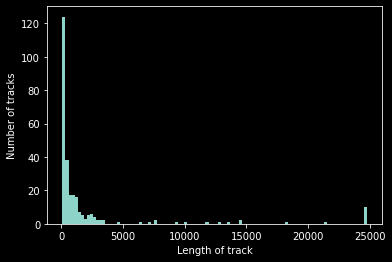

In [5]:
print(f"Total number of tracks {len(raw_tracks)}.")

# Change to 0 if want all tracks
min_length_threshold = 100

track_lengths = []
track_list = []
for track_num, track in enumerate(raw_tracks):
    track_length = track['track'].shape[0]
    if track_length >= min_length_threshold:
        track_lengths.append(track['track'].shape[0])
        track_list.append(track)
    
print(f"Number of tracks above min threshold {len(track_lengths)}.")
plt.hist(track_lengths, bins=100)
plt.xlabel("Length of track")
plt.ylabel("Number of tracks")

In [6]:
save = True
convert_to_top_left = True  # convert from origin at bottom left to top left (annoying but expected for rest of code..)
if save:
    if convert_to_top_left:
        frame_folders_root = os.path.join(local_paths['base_frames_folder'], 
                                          observation_name)
        frame_files = kgf.get_observation_frame_files(frame_folders_root)
        demo_frame = plt.imread(frame_files[0])
        for track in track_list:
            track_copy = np.copy(track['track'])
            track['track'][:, 0] = demo_frame.shape[0] - track_copy[:, 1]
            track['track'][:, 1] = track_copy[:, 0]
    np.save(tracks_file, track_list)

### Examine individual tracks (use the GUI for more careful examination)

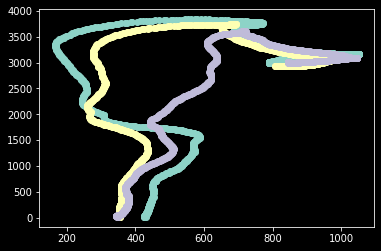

In [7]:
for track in track_list[:3]:
    plt.scatter(track['track'][:,0], track['track'][:,1])

In [16]:
track['pos_index'].shape

(970, 1, 1)